In [145]:
# 622 Stochastic Modeling - GWP 1

############################################################################
##  __     __    __     ______   ______     ______     ______   ______    ##
## /\ \   /\ "-./  \   /\  == \ /\  __ \   /\  == \   /\__  _\ /\  ___\   ##
## \ \ \  \ \ \-./\ \  \ \  _-/ \ \ \/\ \  \ \  __<   \/_/\ \/ \ \___  \  ##
##  \ \_\  \ \_\ \ \_\  \ \_\    \ \_____\  \ \_\ \_\    \ \_\  \/\_____\ ##
##   \/_/   \/_/  \/_/   \/_/     \/_____/   \/_/ /_/     \/_/   \/_____/ ##
##                                                                        ##
############################################################################

import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import brute, fmin
from matplotlib import pyplot as plt

# Step 1.a -- Student A

# Step 1.b -- Student B, Using Carr-Madan (1999) to calibrate Heston (1993)

In [146]:
# Given parameters
r = 1.50 / 100
trading_days = 250
S0 = 232.90

# Load data
filepath = r"C:\Users\Atakan\atakan_python\WQU_DP\WQU_SM\GWP1\MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx"
options = pd.read_excel(filepath, header=0)
options["T"] = options["Days to maturity"] / trading_days
options["r"] = r


# Filter 15 days maturity calls
options = options[(options['Days to maturity'] == 15) & (options['Type'] == 'C')]
options

,Days to maturity,Strike,Price,Type,T,r
0,15,227.5,10.52,C,0.06,0.015
1,15,230.0,10.05,C,0.06,0.015
2,15,232.5,7.75,C,0.06,0.015
3,15,235.0,6.01,C,0.06,0.015
4,15,237.5,4.75,C,0.06,0.015


In [147]:
import numpy as np

def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Characteristic function for the Heston model."""
    # Parameters for the characteristic function
    alpha = -u * u * 0.5 - u * 0.5j
    beta = kappa_v - rho * sigma_v * u * 1j
    gamma = sigma_v ** 2 / 2
    d = np.sqrt(beta ** 2 - 4 * alpha * gamma)
    rp = (beta + d) / (2 * gamma)
    rm = (beta - d) / (2 * gamma)
    g = rm / rp
    # Avoid division by zero and log of zero
    exp_dT = np.exp(-d * T)
    G = (1 - g * exp_dT) / (1 - g)
    # Characteristic function
    C = r * u * 1j * T + (kappa_v * theta_v) / (sigma_v ** 2) * (
        (beta - d) * T - 2 * np.log(G)
    )
    D = (beta - d) / (sigma_v ** 2) * ((1 - exp_dT) / (1 - g * exp_dT))
    char_func_value = np.exp(C + D * v0)
    return char_func_value

def H93_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Call option price in Heston (1993) under FFT (Carr and Madan approach)"""
    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # In-the-money case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / (alpha ** 2 + alpha - vo ** 2 + 1j * (2 * alpha + 1) * vo)
        )
    else:  # Out-of-the-money case
        alpha = 1.1
        v = vo - 1j * (alpha + 1)
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - H93_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )
        v = vo + 1j * (alpha - 1)
        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - H93_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

def put_price_from_call(call_price, S0, K, T, r):
    """
    Calculates the European put option price using Put-Call parity.

    Parameters:
    ===========
    call_price : float
        Price of the European call option.
    S0 : float
        Current stock/index level.
    K : float
        Strike price.
    T : float
        Time to maturity (in years).
    r : float
        Constant risk-free short rate.

    Returns:
    ========
    put_price : float
        Price of the European put option.
    """
    put_price = call_price + K * np.exp(-r * T) - S0
    return put_price


In [148]:
# H93 Calibration

i = 0
min_MSE = 500

def H93_error_function(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        model_value = H93_call_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 1.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.01),  # sigma_v
            (-0.75, 0.01, 0.1),  # rho
            (0.01, 0.031, 0.01),  # v0
        ),
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=1500, maxfun=900
    )
    return opt

def H93_calculate_model_values(p0):
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    values = []
    for row, option in options.iterrows():
        model_value = H93_call_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0
        )

        values.append(model_value)

    return np.array(values)

In [149]:
# Get optimum parameter values
kappa_v, theta_v, sigma_v, rho, v0 = H93_calibration_full()
student_B_full_params = kappa_v, theta_v, sigma_v, rho, v0

print("Optimum parameters =", student_B_full_params)

   0 | [ 2.5   0.01  0.05 -0.75  0.01] |  23.560 |  23.560
  25 | [ 2.5   0.01  0.06 -0.75  0.02] |  16.683 |  11.974
  50 | [ 2.5   0.01  0.07 -0.75  0.03] |  11.969 |  11.969
  75 | [ 2.5   0.01  0.08 -0.65  0.01] |  23.559 |  11.967
 100 | [ 2.5   0.01  0.09 -0.65  0.02] |  16.683 |  11.966
 125 | [ 2.5   0.01  0.1  -0.65  0.03] |  11.970 |  11.964
 150 | [ 2.5   0.01  0.11 -0.55  0.01] |  23.568 |  11.964
 175 | [ 2.5   0.01  0.12 -0.55  0.02] |  16.692 |  11.963
 200 | [ 2.5   0.01  0.13 -0.55  0.03] |  11.978 |  11.963
 225 | [ 2.5   0.01  0.14 -0.45  0.01] |  23.587 |  11.963
 250 | [ 2.5   0.01  0.15 -0.45  0.02] |  16.709 |  11.963
 275 | [ 2.5   0.01  0.16 -0.45  0.03] |  11.993 |  11.963
 300 | [ 2.5   0.01  0.17 -0.35  0.01] |  23.616 |  11.963
 325 | [ 2.5   0.01  0.18 -0.35  0.02] |  16.734 |  11.963
 350 | [ 2.5   0.01  0.19 -0.35  0.03] |  12.014 |  11.963
 375 | [ 2.5   0.01  0.2  -0.25  0.01] |  23.654 |  11.963
 400 | [ 2.5   0.01  0.21 -0.25  0.02] |  16.768 |  11.9

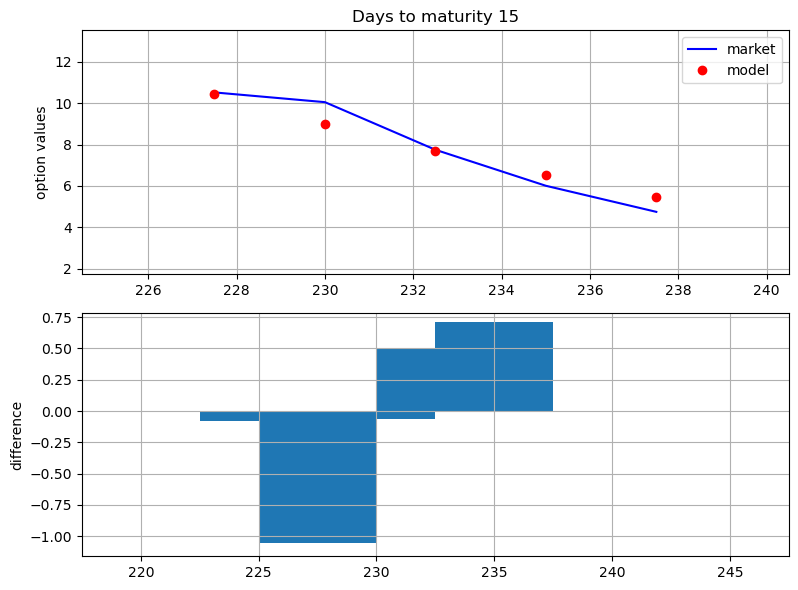

In [150]:
def plot_full_calibration_results(p0):
    options["Model"] = H93_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.grid()
    plt.title("Days to maturity %s" % str(options["Days to maturity"].iloc[0])[:10])
    plt.ylabel("option values")
    plt.plot(options.Strike, options.Price, "b", label="market")
    plt.plot(options.Strike, options.Model, "ro", label="model")
    plt.legend(loc=0)
    plt.axis(
        [
            min(options.Strike) - 3,
            max(options.Strike) + 3,
            min(options.Price) - 3,
            max(options.Price) + 3,
        ]
    )
    plt.subplot(212)
    plt.grid()
    wi = 5.0
    diffs = options.Model.values - options.Price.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel("difference")
    plt.axis(
        [
            min(options.Strike) - 10,
            max(options.Strike) + 10,
            min(diffs) * 1.1,
            max(diffs) * 1.1,
        ]
    )
    plt.tight_layout()

plot_full_calibration_results(student_B_full_params)

# Step 1.c -- Student C

# Step 2.a -- Student C

# Step 2.b -- Student A

# Step 2.c -- Student B


Simulating Heston Model Paths...
Simulation completed.

Pricing Asian Put Option...
Asian Put Option Price: $ 4.6964
95% Confidence Interval: [4.6398, 4.7530]


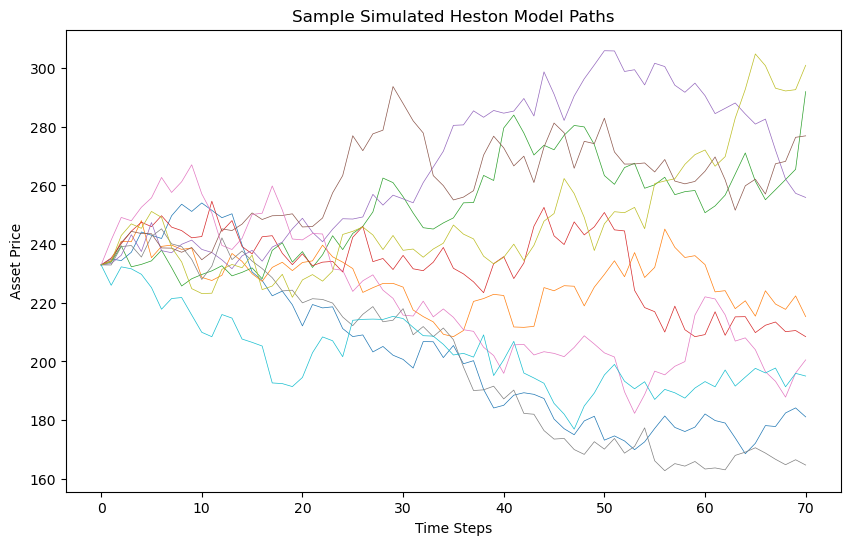

In [153]:
# Given parameters
r = 1.50 / 100
trading_days = 250
S0 = 232.90
T = 70 / trading_days  # 70 days to maturity
K = 0.95 * S0  # 0.95 moneyness

def simulate_heston_paths(S0, T, r, kappa_v, theta_v, sigma_v, rho, v0, 
                         num_simulations=100000, num_steps=70):
    """
    Simulate asset price paths under the Heston model using the Euler-Maruyama method
    with Full Truncation to ensure non-negative variance.
    
    Parameters:
    ===========
    S0 : float
        Initial asset price.
    T : float
        Time to maturity (in years).
    r : float
        Risk-free interest rate.
    kappa_v : float
        Mean-reversion rate of variance.
    theta_v : float
        Long-term mean of variance.
    sigma_v : float
        Volatility of variance.
    rho : float
        Correlation between the two Brownian motions.
    v0 : float
        Initial variance.
    num_simulations : int
        Number of Monte Carlo simulations.
    num_steps : int
        Number of time steps.
    
    Returns:
    ========
    S_paths : ndarray
        Simulated asset price paths of shape (num_simulations, num_steps + 1).
    """
    dt = T / num_steps
    # Initialize arrays
    S_paths = np.zeros((num_simulations, num_steps + 1))
    v_paths = np.zeros((num_simulations, num_steps + 1))
    S_paths[:, 0] = S0
    v_paths[:, 0] = v0
    
    # Precompute constants
    sqrt_dt = np.sqrt(dt)
    # Correlated random variables
    np.random.seed(42)  # For reproducibility
    Z1 = np.random.standard_normal((num_simulations, num_steps))
    Z2 = np.random.standard_normal((num_simulations, num_steps))
    W1 = Z1
    W2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2
    
    for t in range(1, num_steps + 1):
        v_prev = v_paths[:, t - 1]
        # Ensure variance is non-negative (Full Truncation Euler)
        v_prev_clipped = np.maximum(v_prev, 0)
        # Update variance
        dv = kappa_v * (theta_v - v_prev_clipped) * dt + sigma_v * np.sqrt(v_prev_clipped) * sqrt_dt * W2[:, t - 1]
        v_new = v_prev + dv
        v_new = np.maximum(v_new, 0)  # Full Truncation
        v_paths[:, t] = v_new
        
        # Update asset price
        dS = r * S_paths[:, t - 1] * dt + np.sqrt(v_prev_clipped) * S_paths[:, t - 1] * sqrt_dt * W1[:, t - 1]
        S_new = S_paths[:, t - 1] + dS
        S_paths[:, t] = S_new
    
    return S_paths

def price_asian_put_mc(S_paths, K, r, T):
    """
    Price an Asian Put option using Monte Carlo simulation.
    
    Parameters:
    ===========
    S_paths : ndarray
        Simulated asset price paths of shape (num_simulations, num_steps + 1).
    K : float
        Strike price.
    r : float
        Risk-free interest rate.
    T : float
        Time to maturity (in years).
    
    Returns:
    ========
    put_price : float
        Estimated price of the Asian Put option.
    """
    # Include S0 in the average
    average_S = np.mean(S_paths, axis=1)
    # Calculate payoffs
    payoffs = np.maximum(K - average_S, 0)
    # Discount payoffs
    discounted_payoffs = np.exp(-r * T) * payoffs
    # Estimate option price
    put_price = np.mean(discounted_payoffs)
    # Calculate 95% confidence interval
    std_error = np.std(discounted_payoffs) / np.sqrt(len(discounted_payoffs))
    confidence_interval = (put_price - 1.96 * std_error, put_price + 1.96 * std_error)
    
    return put_price, confidence_interval

def calc_asian_put():
    # Given parameters
    r = 1.50 / 100  # Risk-free rate
    trading_days = 250
    S0 = 232.90  # Initial asset price
    T_days = 70  # Days to maturity
    T = T_days / trading_days  # Time to maturity in years
    K = 0.95 * S0  # Strike price (0.95 moneyness)
    
    # Calibrated Heston parameters (from calibration step)
    kappa_v, theta_v, sigma_v, rho, v0 = student_B_full_params
    
    # Monte Carlo parameters
    num_simulations = 100000  # Number of Monte Carlo simulations
    num_steps = T_days  # Daily steps
    
    print("\nSimulating Heston Model Paths...")
    S_paths = simulate_heston_paths(
        S0=S0,
        T=T,
        r=r,
        kappa_v=kappa_v,
        theta_v=theta_v,
        sigma_v=sigma_v,
        rho=rho,
        v0=v0,
        num_simulations=num_simulations,
        num_steps=num_steps
    )
    print("Simulation completed.")
    
    print("\nPricing Asian Put Option...")
    put_price, confidence_interval = price_asian_put_mc(S_paths, K, r, T)
    print(f"Asian Put Option Price: $ {put_price:.4f}")
    print(f"95% Confidence Interval: [{confidence_interval[0]:.4f}, {confidence_interval[1]:.4f}]")
    
    # Optional: Plot a few simulated paths
    plt.figure(figsize=(10,6))
    for i in range(10):
        plt.plot(S_paths[i, :], lw=0.5)
    plt.title('Sample Simulated Heston Model Paths')
    plt.xlabel('Time Steps')
    plt.ylabel('Asset Price')
    plt.show()

    return put_price

put_price = calc_asian_put()

In [157]:
price_with_fee = put_price * 1.04
print("Asian Put Price with 4% fee: $", np.round(price_with_fee, 4))

Asian Put Price with 4% fee: $ 4.8842


### Brief description about the process to the client

To price the Asian Put option accurately, we employed the **Heston (1993)** Stochastic Volatility Model. The Heston model recognizes that volatility—a measure of an asset's price fluctuations—can vary over time, capturing more realistic market behaviors.

We began by sourcing real market data, specifically focusing on European call options with a 15-day maturity. This data includes various strike prices and corresponding option prices, which serve as benchmarks for **calibration**.

Using a **brute-force** approach, we scanned a range of plausible values for each parameter to identify regions where the model's outputs closely match market prices. Leveraging advanced optimization techniques, we fine-tuned these parameters to minimize discrepancies between the model's predictions and actual market data, ensuring the highest possible accuracy.

With calibrated parameters in hand, we proceeded to simulate the future behavior of the underlying asset's price. Once the asset price paths were simulated, we proceeded to determine the option's fair price based on these trajectories. The simulation yielded a fair price for the Asian Put option, complemented by a confidence interval, ensuring that the pricing is both accurate and robust against market uncertainties.

Finally, to account for transaction costs and other associated fees, we applied a fair **4%** fee to the computed option price.

# Step 3.a -- as a TEAM

In [168]:
# year fraction, rates
rates_dict = {
    7 / 360: 0.00648,
    30 / 360: 0.00679,
    90 / 360: 0.01173,
    180 / 360: 0.01809,
    360 / 360: 0.02556
}

rates = pd.Series(rates_dict, name="rates")
rates

0.019444    0.00648
0.083333    0.00679
0.250000    0.01173
0.500000    0.01809
1.000000    0.02556
Name: rates, dtype: float64

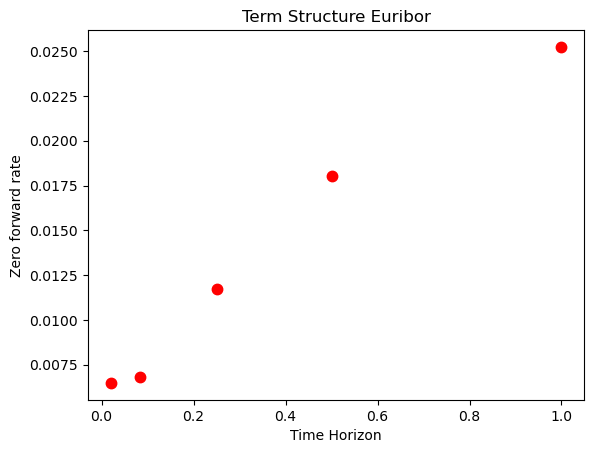

In [170]:
r0 = rates.iloc[0]
factors = 1 + rates.index * rates
zero_rates = 1 / rates.index * np.log(factors)

plt.plot(rates.index, zero_rates, "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.show()

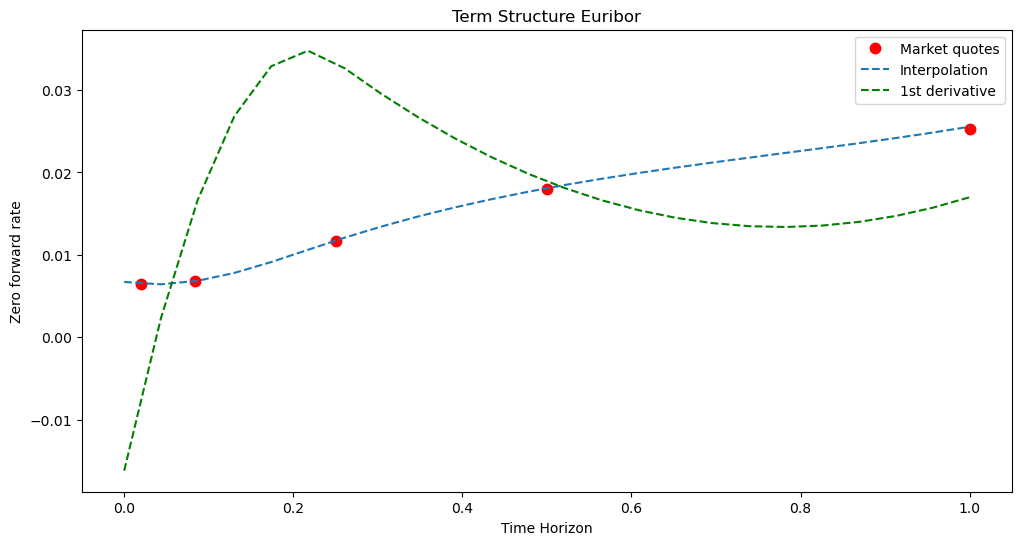

In [171]:
from scipy.interpolate import splev, splrep

bspline = splrep(rates.index, rates, k=3)  # Cubic spline
mat_list_n = np.linspace(
    0.0, 1.0, 24
)  # Create 24 equally spaced maturities between 0 and 1
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

plt.figure(figsize=(12, 6))
plt.plot(rates.index, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(mat_list_n, inter_rates, "--", markersize="10", label="Interpolation")
plt.plot(mat_list_n, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

In [172]:
from scipy.optimize import fmin

def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

params = CIR_calibration()
params

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 152
         Function evaluations: 275


array([0.96521201, 0.11289787, 0.00101249])

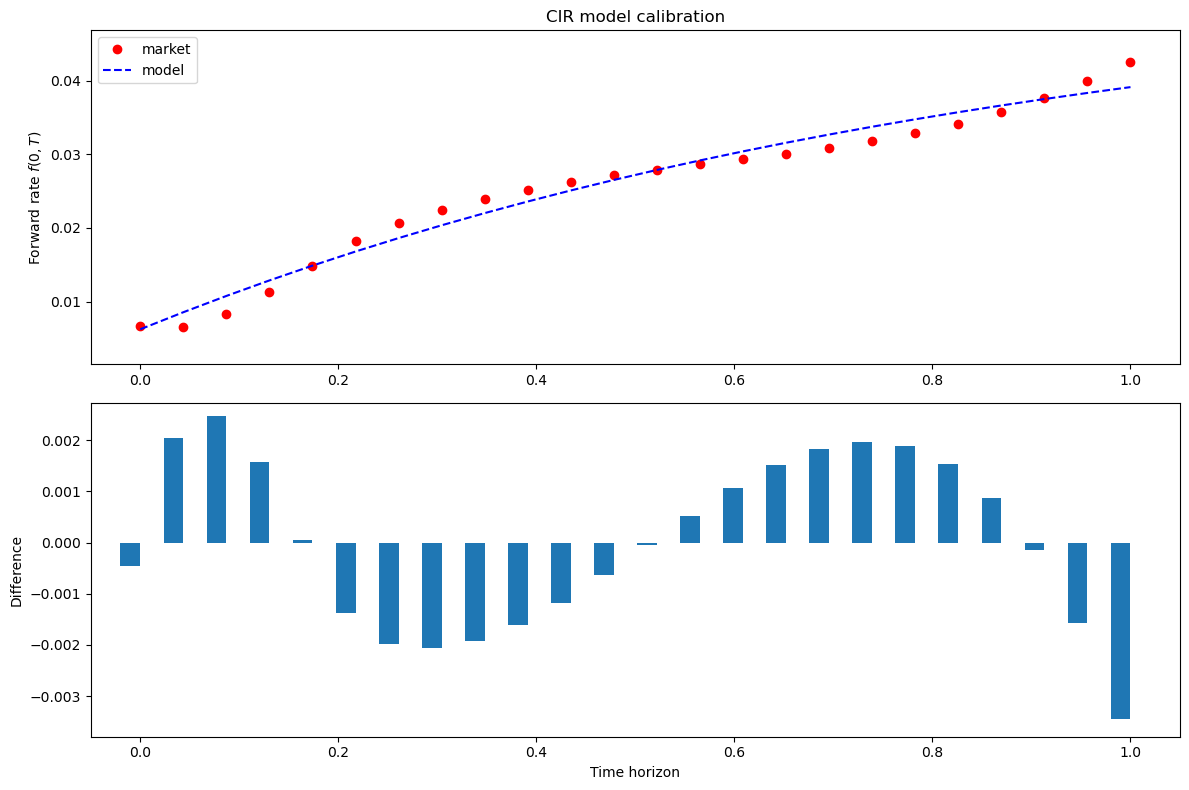

In [173]:
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

plot_calibrated_frc(params)

# Step 3.b -- as a TEAM